# Utilisation du Grad_CAM pour un réseau VGG19
___

Ce code est inspiré de plusieurs articles et livres pour implémenter un Grad_CAM sur un réseau VGG19 avec des images issus de la banque d'image ImageNet. Comme certaines fonctionnalités ne sont pas présentes dans PyTorch, nous allons faire cette implémentation en suivant plusieurs étapes :
- Charger le modèle VGG19
- Trouver sa dernière couche convolutive
- Calculer la classe la plus probable
- Prenez le gradient du logit de classe par rapport aux cartes d’activation que nous venons d’obtenir
- Regrouper les dégradés
- Pondérer les canaux de la carte par les gradients groupés correspondants
- Interpoler la carte thermique

## 1ère étape : charger le modèle VGG19

Ici, j’importe tous les éléments standard que nous utilisons pour travailler avec les réseaux de neurones dans PyTorch. J’utilise la transformation de base nécessaire pour utiliser n’importe quel modèle formé sur le jeu de données ImageNet, y compris la normalisation de l’image. Je vais nourrir une image à la fois, c’est pourquoi je définis mon ensemble de données comme étant l’image des éléphants, dans le but d’obtenir des résultats similaires à ceux de l'article. 

In [1]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='./data/Elephants', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)


## 2eme étape : trouver la dernière couche convolutive

Il y a un instrument de rappel dans PyTorch : les crochets. 
Les crochets peuvent être utilisés dans différents scénarios, le nôtre est l’un d’entre eux. La documentation nous dit :

___"Le crochet sera appelé chaque fois qu’un gradient par rapport au tenseur est calculé."___

Nous savons maintenant que nous devons enregistrer le crochet arrière sur la carte d’activation de la dernière couche convolutive de notre modèle VGG19. Trouvons où accrocher. 
On peut facilement observer l’architecture VGG19 en appelant : _vgg19(pretrained=True)_

In [2]:
vgg19(pretrained=True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Dans l’image, nous voyons toute l’architecture VGG19. La dernière couche convolutive est donc ___(34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))___ (avec sa fonction d'activation ___(35): ReLU(inplace=True)___). Eh bien, nous savons maintenant que nous voulons enregistrer le crochet arrière à la 35ème couche du bloc de fonctionnalités de notre réseau.

In [3]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

## 3ème étape : calculer sa classe la plus probable

Tout d’abord, faisons passer le foward pass à travers le réseau avec l’image des éléphants et voyons ce que le VGG19 prédit. N’oubliez pas de mettre votre modèle en mode d’évaluation, sinon vous pouvez obtenir des résultats très aléatoires:

In [4]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

# get the most likely prediction of the model
pred = vgg(img)

In [5]:
pred.argmax(dim=1) 

tensor([386])

## 4ème étape : prendre le gradient de logit de la classe probable et interpoler la carte graphique

Maintenant, nous allons faire la rétro-propagation avec le logit de la 386ème classe qui représente le 'African_elephant' dans le jeu de données ImageNet.

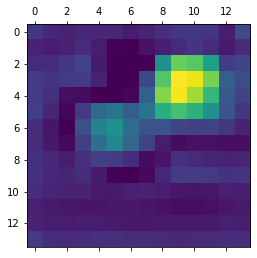

In [6]:
# get the gradient of the output with respect to the parameters of the model
pred[:, 386].backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

Enfin, nous obtenons la carte thermique pour l’image de l’éléphant. Il s’agit d’une image monocanal 14x14. __La taille est dictée par les dimensions spatiales des cartes d’activation dans la dernière couche convolutive du réseau.__

Maintenant, nous pouvons utiliser OpenCV pour interpoler la carte thermique et la projeter sur l’image originale.

In [10]:
import cv2

img = cv2.imread('./data/Elephants/data/elephants.jpg')

heatmap = np.array(heatmap)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('./map.jpg', superimposed_img)

True

Dans l’image ci-dessous, nous pouvons voir les zones de l’image que notre réseau VGG19 a prises le plus au sérieux pour décider quelle classe (« African_elephant ») attribuer à l’image. Nous pouvons supposer que le réseau a pris la forme de la tête et des oreilles des éléphants comme un signe fort de la présence d’un éléphant dans l’image.

Nous pouvons tester avec d'autres images, tels que des chats, des chiens, des requins, etc... Nous pouvons aussi tester d'autres modèles de CNN et voir la différence.